##### Import packages

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Step 1: Calcuate Camera Calibration Matrix and Distortion Coefficients and apply distortion correction to raw image

#### Find the chessboard corners

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

##### Undistort camera image

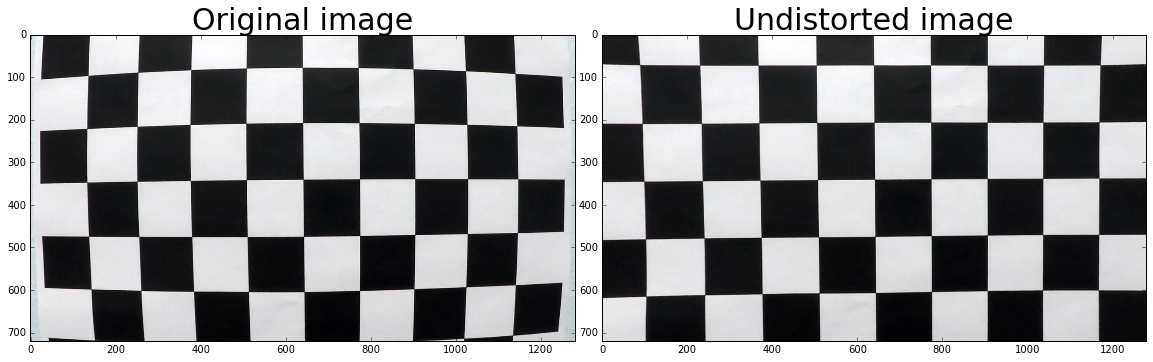

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted image', fontsize=30)

##### Undistort Test Image

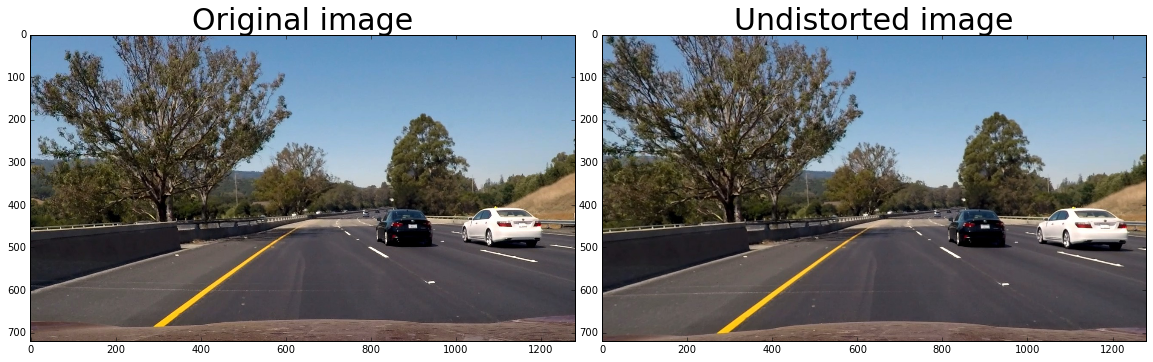

In [4]:
# Test undistortion on an image
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Do camera calibration given object points and image points
undist_test_image = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(undist_test_image)
ax2.set_title('Undistorted image', fontsize=30)

### Step 2: Use color transforms and gradients to create a thresholded binary image

##### Gradienet Threshold with Sobel Operator

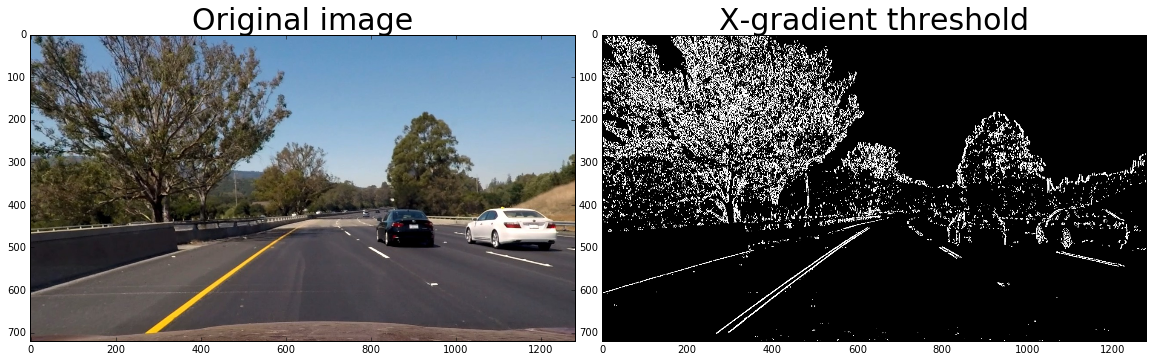

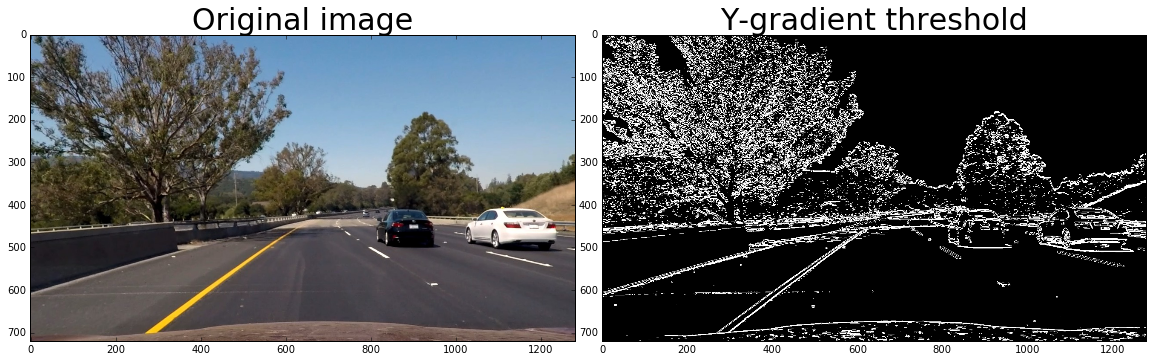

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= thresh[0]) & (scale_sobel <= thresh[1])] = 1
    
    return binary_output

# Run the gradient binary for absolute sobel
gradx_binary = abs_sobel_thresh(undist_test_image, orient='x', thresh=(20, 100))
grady_binary = abs_sobel_thresh(undist_test_image, orient='y', thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(gradx_binary, cmap='gray')
ax2.set_title('X-gradient threshold', fontsize=30)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(grady_binary, cmap='gray')
ax2.set_title('Y-gradient threshold', fontsize=30)

##### Magnitude of the gradient

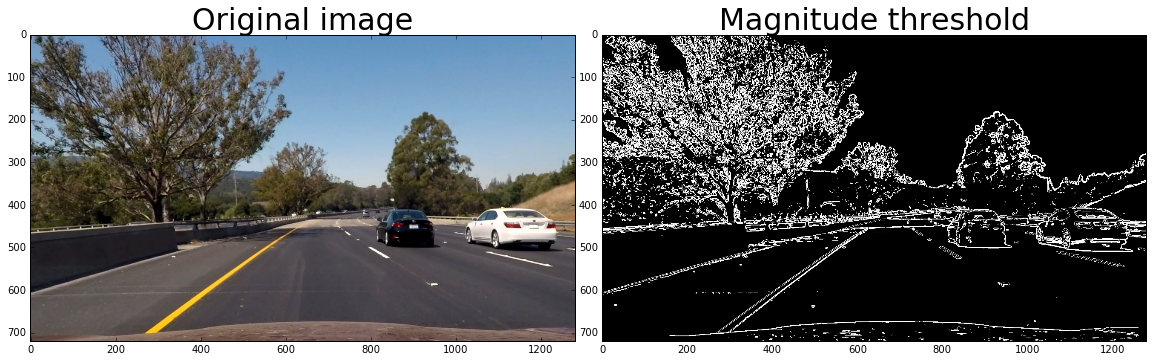

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output
    
# Run the function
mag_binary = mag_thresh(undist_test_image, sobel_kernel=3, mag_thresh=(30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Magnitude threshold', fontsize=30)

##### Direction of the gradient

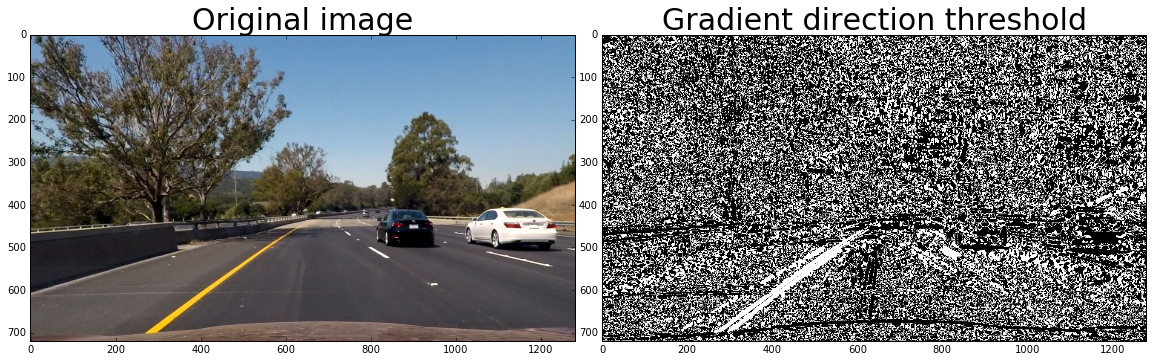

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output
    
# Run the function
dir_binary = dir_threshold(undist_test_image, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Gradient direction threshold', fontsize=30)

##### Combining gradient thresholds

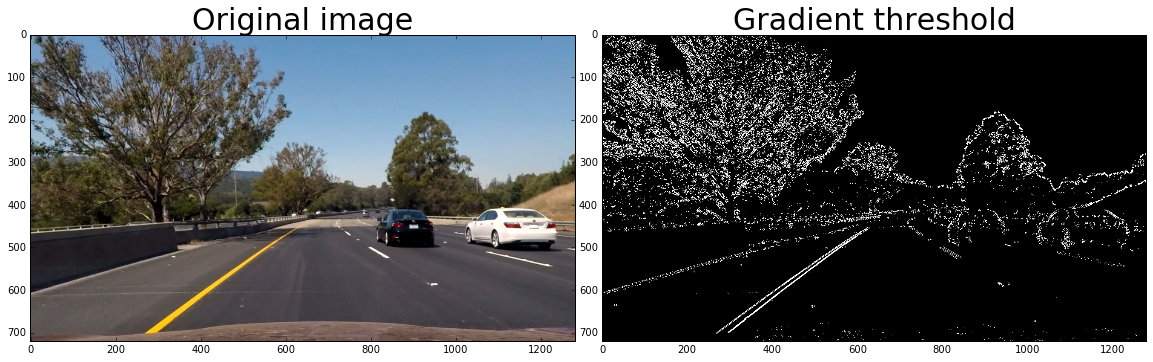

In [8]:
def combined_threshold(gradx_binary, grady_binary, mag_binary, dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx_binary = abs_sobel_thresh(undist_test_image, orient='x', sobel_kernel=ksize, thresh=(20,100))
grady_binary = abs_sobel_thresh(undist_test_image, orient='y', sobel_kernel=ksize, thresh=(20,100))
mag_binary = mag_thresh(undist_test_image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(undist_test_image, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Run the function
gradient_binary = combined_threshold(gradx_binary, grady_binary, mag_binary, dir_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(gradient_binary, cmap='gray')
ax2.set_title('Gradient threshold', fontsize=30)

##### HLS and color thresholds

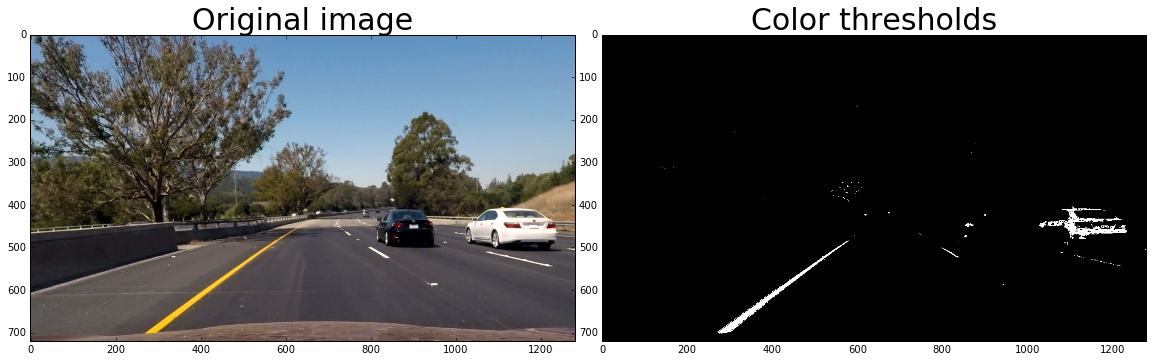

In [9]:
def hls_select(img, s_thresh=(0, 255), l_thresh = (0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) 
             & (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1    
    return binary_output
    
# Run the function
hls_binary = hls_select(undist_test_image, s_thresh=(170, 255), l_thresh = (30, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Color thresholds', fontsize=30)

##### Combined color and gradient thresholds

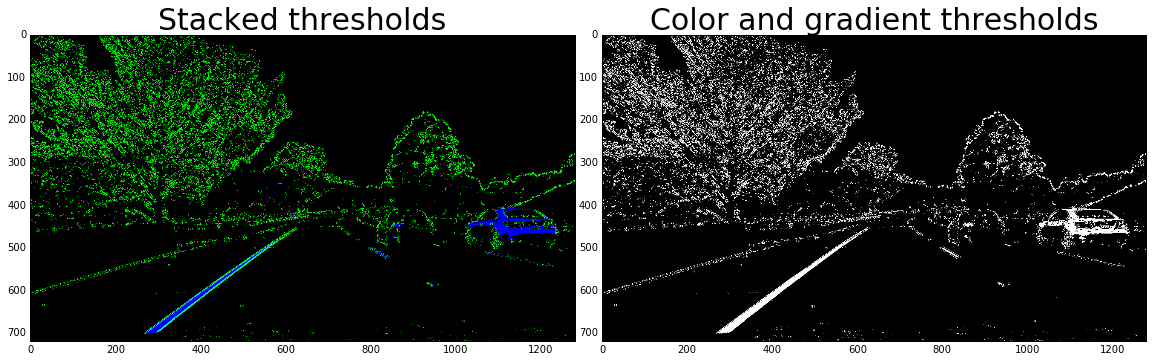

In [10]:
def color_and_gradient(gradient_binary, hls_binary):   
    binary_output = np.zeros_like(gradient_binary)
    binary_output[(hls_binary == 1) | (gradient_binary == 1)] = 1
    return binary_output

color_binary = np.dstack(( np.zeros_like(gradient_binary), gradient_binary, hls_binary))
combined_binary = color_and_gradient(gradient_binary, hls_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(color_binary)
ax1.set_title('Stacked thresholds', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Color and gradient thresholds', fontsize=30)

### Step 3: Perspective Transform to binary image

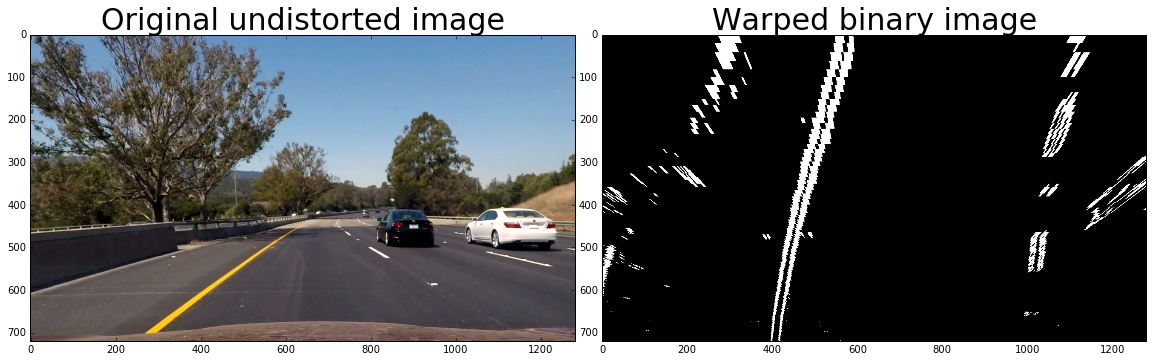

In [11]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    offset = 0.09*img_size[0]
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[img_size[0]*0.46,     img_size[1]*0.63],
                      [img_size[0]*0.20,     img_size[1]*0.95],
                      [img_size[0]*(1-0.20), img_size[1]*0.95],
                      [img_size[0]*(1-0.46), img_size[1]*0.63]])
    
    # For destination points, I'm arbitrarily choosing some points to be a nice fit for 
    # displaying our warped result again, not exact, but close enough for our purposes
    dst = np.float32([[img_size[0]*0.20 + offset, 0], 
                      [img_size[0]*0.20 + offset, img.shape[0]], 
                      [img_size[0]*0.82 - offset, img.shape[0]],
                      [img_size[0]*0.82 - offset, 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Swaps the source and destination to compute the inverse.  Use this later.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

    return warped, Minv

binary_warped, Minv = warp(gradx_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_test_image)
ax1.set_title('Original undistorted image', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped binary image', fontsize=30)

### Step 4: Detect lane pixels and fit to find the lane boundary

##### Implement Sliding Windows and Fit a Polynomial

In [12]:
def sliding_windows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                          & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit

(720, 0)

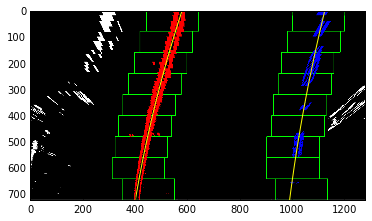

In [13]:
out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = sliding_windows(binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

##### Skip the sliding windows step once you know where the lines are

In [14]:
def detect_lane(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                      & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, ploty, left_fitx, right_fitx, left_fit, right_fit

(720, 0)

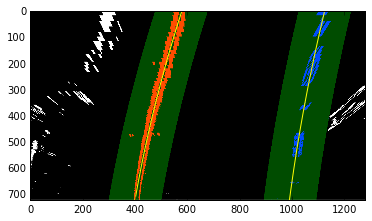

In [15]:
result, ploty, left_fitx, right_fitx, left_fit, right_fit = detect_lane(binary_warped, left_fit, right_fit)    

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Step 5: Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

##### Project your measurement back down onto the road

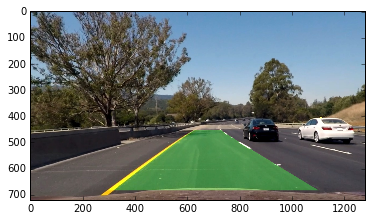

In [16]:
def drawing_lane(binary_warped, undist_image, Minv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    return result

plt.imshow(drawing_lane(binary_warped, undist_test_image, Minv, ploty, left_fitx, right_fitx))

##### Measuring curvature

In [17]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720  # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measuring_curvature(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                        / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) \
                        / np.absolute(2*right_fit_cr[0])
        
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

print(measuring_curvature(ploty, left_fitx, right_fitx))   

(1607.8528681461594, 2164.7808517687886)


#####  Offset of the lane center

In [18]:
def offset_to_lane_center(image, left_fitx, right_fitx):
    camera_center_at_bottom = (left_fitx[-1]+right_fitx[-1])/2
    center = image.shape[1]/2
    center_diff = (camera_center_at_bottom - center)*xm_per_pix
    
    return center_diff

print(offset_to_lane_center(undist_test_image, left_fitx, right_fitx))

0.294572974297


### Pipeline to process each frame

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [20]:
class Lanes:
    current = None
    last_known_good = None

In [21]:
def pipeline(image):
    
    ksize=3
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)

    gradx_binary = abs_sobel_thresh(undist_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady_binary = abs_sobel_thresh(undist_image, orient='y', sobel_kernel=ksize, thresh=(20,100))
    mag_binary = mag_thresh(undist_image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    gradient_binary = combined_threshold(gradx_binary, grady_binary, mag_binary, dir_binary)  
    
    hls_binary = hls_select(undist_image, s_thresh=(170, 255), l_thresh = (30, 255))
    combined_binary = color_and_gradient(gradient_binary, hls_binary)

    binary_warped, Minv = warp(combined_binary)
    
    out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = sliding_windows(binary_warped)
    result,  ploty, left_fitx, right_fitx, left_fit, right_fit = detect_lane(binary_warped, left_fit, right_fit)
        
    left_curverad, right_curverad = measuring_curvature(ploty, left_fitx, right_fitx)
    center_diff = offset_to_lane_center(binary_warped, left_fitx, right_fitx)
    
    #check if left_curverad and right_curverad is < 2500, if more that 2500, it is a strightline
    # Make sure the center is not too off, when it is over is range, it detect the wrong path
    if (center_diff > 0.00 and center_diff < 0.70):
        Lanes.current = [ploty, left_fitx, right_fitx]
        Lanes.last_good = [ploty, left_fitx, right_fitx]
    else:
        Lanes.current = Lanes.last_good
        
    result = drawing_lane(binary_warped, undist_image, Minv, \
                    Lanes.current[0], Lanes.current[1], Lanes.current[2])
    
    cv2.putText(result, 'Curvature radius: {0} m. '.format((int(left_curverad) + int(right_curverad)) / 2 ),
                (25,75),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(result, 'Distance from center: {0} m. '.format(( np.math.ceil(abs(center_diff) * 100) / 100)),
                (25, 125), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 2, cv2.LINE_AA)
    
    return result

##### Numerical estimation of lane curvature and vehicle position

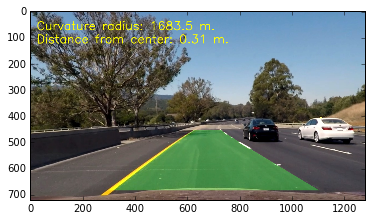

In [22]:
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(pipeline(img))

##### Project video

In [23]:
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:29<00:00,  3.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 30s
